In [13]:
import os

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from bio_optics.helper import resampling, utils, owt, indices, plotting

In [21]:
## apply to full EnMAP extracts
## North Sea extracts, EnMAP
datasetName='NorthSeaEnMAPSouth20230815'
df = pd.read_csv(r'Z:\projects\ongoing\EnsAD\workspace\data\Database\\20230815_DB\\20230815_South.csv')
# print(df.columns.values)
a = [str(b) for b in df['OWT'].values]
df['OWT']=np.asarray(a)
# print(np.unique(df['OWT']))
IDvalid = np.array(df['OWT'].values != 'nan')

wavelengths = df.columns[4:84].values.astype(float)
wavelengths = wavelengths[(wavelengths>400) & (wavelengths<750)]
r_rs = df.iloc[:,4:len(wavelengths)+4]
r_rs = r_rs.loc[IDvalid,:]
df = df.loc[IDvalid,:]

selectionIndex = pd.read_csv(r'E:\Documents\projects\EnsAD\data\EnMAP_NN_training\AANN_NorthSea\trainingDataIndex_InvertibleEnMAPSpectra_NorthSeaEnMAPSouth20230815_selection20240405.txt',
                             header=0, sep='\t')
print(selectionIndex.shape, df.shape)

(1276, 1) (1276, 98)


In [23]:
# path = "E:\Documents\projects\EnsAD\\NN_training\AANN_EnMAP\\aann_EnMAP_20240405_v01\I60x31x7x31xO60_\\temp\\"
path = "E:\Documents\projects\EnsAD\\NN_training\AANN_EnMAP\\aann_EnMAP_20240405_v01\I60x80x20x80xO60_\\temp\\"
fnames = os.listdir(path)
print(fnames)

['I60x80x20x80xO60batch50_epoch30000_loss0.05781.h5', 'I60x80x20x80xO60_batch50_epoch1767_loss0.04356.h5', 'I60x80x20x80xO60_batch50_epoch19828_loss0.04268.h5', 'I60x80x20x80xO60_batch50_epoch20953_loss0.04031.h5', 'I60x80x20x80xO60_batch50_epoch21895_loss0.03994.h5', 'I60x80x20x80xO60_batch50_epoch6709_loss0.04328.h5', 'I60x80x20x80xO60_batch50_epoch960_loss0.04491.h5', 'loss_I60x80x20x80xO60batch50_epoch30000_loss0.05781.png']


In [24]:
# modelFname = 'I60x31x7x31xO60_batch50_epoch12143_loss0.04057.h5'
modelFname = 'I60x80x20x80xO60_batch50_epoch21895_loss0.03994.h5'
model_ = tf.keras.models.load_model(path + modelFname)
AANN_pred = model_.predict(r_rs)

40/40 [==============================] - 0s 2ms/step


(1276, 60)


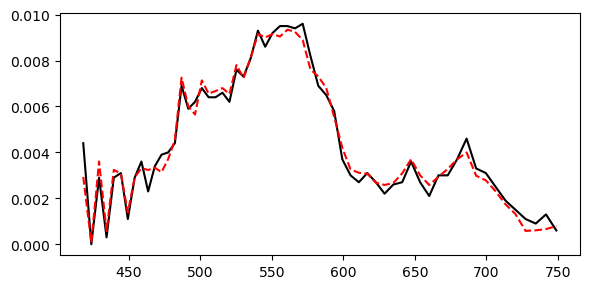

In [25]:
print(AANN_pred.shape)
i = 8
fig, ax=plt.subplots(nrows=1, ncols=1, figsize=(6,3))
ax.plot(wavelengths, r_rs.iloc[i,:], 'k-')
ax.plot(wavelengths, AANN_pred[i,:], 'r--')
fig.tight_layout()
plt.show()

In [26]:
## error
rMAE = np.zeros(r_rs.shape[0])
sam = np.zeros(r_rs.shape[0])

for i in range(len(rMAE)):
    rMAE[i] = np.mean(utils.compute_residual(r_rs.iloc[i].values, AANN_pred, method=11))
    sam[i] = np.sum(r_rs.iloc[i].values * AANN_pred[i,:])/\
                 (np.sqrt(np.sum(r_rs.iloc[i].values*r_rs.iloc[i].values)) * np.sqrt(np.sum(AANN_pred[i,:]*AANN_pred[i,:])))
    sam[i] = np.arccos(sam[i])
    
sam *=180./np.pi

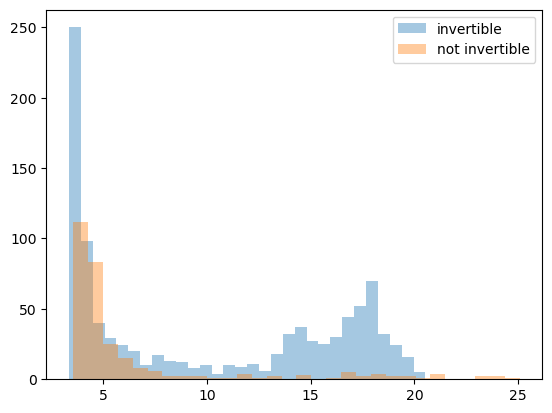

In [27]:
plt.hist(rMAE[selectionIndex['selection']], bins=30, alpha=0.4, label='invertible')
plt.hist(rMAE[np.logical_not(selectionIndex['selection'])], bins=30, alpha=0.4, label='not invertible')
plt.legend()
plt.show()